In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import resample,shuffle
import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV


# Data Description

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.



In [2]:
df= pd.read_csv('dataset/creditcard.csv')

# 1) Exploratory Data Analysis

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Missing data check

In [4]:
df.isnull().mean()*100

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

The previous result shows that there are no missing data.

# 2) Data preparation and model training:

## Data preparation

In the modeling phase, we will use XGBoost as our base model. Since it is insensitive to feature scaling and outliers, we don't need to worry about them in the dataset. 

We split the dataset 10 % for testing and 90% for training. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df,df['Class'], test_size=0.1, random_state=42)
print(f'X_train lenght {len(X_train)}. X_test lenght {len(X_test)}')

X_train lenght 256326. X_test lenght 28481


We should keep the test dataset aside for future analysis.

In [6]:
X_test.to_csv('dataset/test_dataset.csv',index=False) 

Let's examine how fraudulent and non-fraudulent transactions are distributed within both the training and testing datasets.

In [7]:
print( "Train dataste\n",X_train['Class'].value_counts())
print("\n")
print("Test dataset \n",X_test['Class'].value_counts())

Train dataste
 0    255880
1       446
Name: Class, dtype: int64


Test dataset 
 0    28435
1       46
Name: Class, dtype: int64


In [8]:
# here we split the dataset into features and label
y_train = X_train['Class']
x_train =  X_train.drop(columns=['Class'],axis=1)

y_test = X_test['Class']
x_test =  X_test.drop(columns=['Class'],axis=1)


## Modeling

### Hyperparameters tuning for Xgboost

We employ the GridSearchCV technique to discover the optimal hyperparameters for XGBoost within a specified grid of parameter values.

We set 'n_jobs' to 10 to leverage multithreading for enhanced parallel computation.

In [9]:

param_test1 = {
 'max_depth':[3,5,15],
 'learning_rate': [0.1],
 'min_child_weight':[10, 20]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140,
                                                      gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', nthread=4, seed=27), 
                                                      param_grid = param_test1, scoring='roc_auc',n_jobs=10, cv=10, )
gsearch1.fit(x_train,y_train)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=140,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 5, 15],
                         'min_child_weight': [10, 20]},
             scoring='roc_auc')

In [10]:
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10},
 0.9823456169479696)

0.1

In [11]:
model = xgb.XGBClassifier(n_estimators=140,
                          learning_rate = gsearch1.best_params_['learning_rate'],
                          max_depth = gsearch1.best_params_['max_depth'],
                          min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, seed=27)

model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = model.predict(x_test)
y_test = np.array(y_test).astype(int)
auc_lr = roc_auc_score(y_test, y_pred)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred)
matthews_corrcoef(y_test, y_pred)


0.8598871352080946

# Upsampling


Before performing upsampling/downsampling, we split the dataset into train and test datasets to prevent data leakage.  

In [13]:
#Set the minority class to a seperate dataframe
df_1 = X_train[X_train['Class'] == 1]
#Set other classes to another dataframe
other_df = X_train[X_train['Class'] != 1]  
#Upsample the minority class
df_1_upsampled = resample(df_1,random_state=42,n_samples=len(other_df),replace=True)
#Concatenate the upsampled dataframe
df_upsampled = pd.concat([df_1_upsampled,other_df])
df_upsampled['Class'].value_counts() # check whether the upsampling was succeful

1    255880
0    255880
Name: Class, dtype: int64

In [17]:
y_train_up = df_upsampled['Class']
x_train_up =  df_upsampled.drop(columns=['Class'],axis=1)

model_upsampling = xgb.XGBClassifier(n_estimators=140,
                          learning_rate = gsearch1.best_params_['learning_rate'],
                          max_depth = gsearch1.best_params_['max_depth'],
                          min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, seed=27)

model_upsampling.fit(x_train_up, y_train_up) # train the model on upsampling dataset


# Prediction with the model with upsampling dataset

y_pred_up = model_upsampling.predict(x_test)
y_test_up = np.array(y_test).astype(int)

# AUC 
auc_lr_up = roc_auc_score(y_test, y_pred_up) # Compute the AUX score of the model
fpr_lr_up, tpr_lr_up, thresholds_lr_up = roc_curve(y_test, y_pred_up)


# Downsampling

In [19]:
#set the minority class to a seperate dataframe
df_2 = X_train[X_train['Class'] == 1]
#set majority classes to another dataframe
other_df = X_train[X_train['Class'] != 1]  
#Downsample the majority class
df_2_upsampled = resample(other_df,random_state=42,n_samples=len(df_2),replace=False) # we set replace to false to avoid data duplication
#concatenate the upsampled dataframe
df_downsampled = pd.concat([df_2_upsampled,df_2])
df_downsampled['Class'].value_counts() # check the distribution of the datatset 

0    446
1    446
Name: Class, dtype: int64

In [20]:
y_train_down = df_downsampled['Class']
x_train_down =  df_downsampled.drop(columns=['Class'],axis=1)
model_downsampling = xgb.XGBClassifier(n_estimators=140,
                          learning_rate = gsearch1.best_params_['learning_rate'],
                          max_depth = gsearch1.best_params_['max_depth'],
                          min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, seed=27)
model_downsampling.fit(x_train_down, y_train_down)


# Prediction 

y_pred_down = model_downsampling.predict(x_test)
y_test = np.array(y_test).astype(int)

# AUC
auc_lr_down = roc_auc_score(y_test, y_pred_down)
fpr_lr_down, tpr_lr_down, thresholds_lr_down = roc_curve(y_test, y_pred_down)

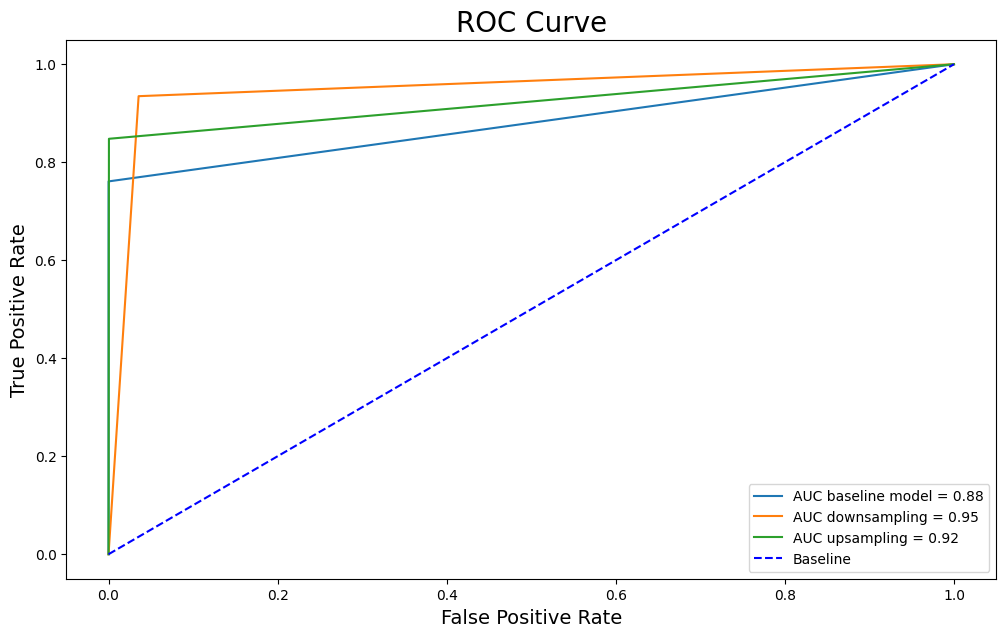

In [21]:

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC baseline model = {auc_lr:.2f}')
plt.plot(fpr_lr_down, tpr_lr_down, label=f'AUC downsampling = {auc_lr_down:.2f}')
plt.plot(fpr_lr_up, tpr_lr_up, label=f'AUC upsampling = {auc_lr_up:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

In [22]:
print(f'Matthews correlation coefficient for is : \n {matthews_corrcoef(y_test, y_pred)} for unbanced dasete, \n {matthews_corrcoef(y_test, y_pred_up)} for upsampling model \n and {matthews_corrcoef(y_test, y_pred_down)} for downsampling')

Matthews correlation coefficient for is : 
 0.8598871352080946 for unbanced dasete, 
 0.797068398853841 for upsampling model 
 and 0.1912783491947603 for downsampling


# Save the best model 

In [24]:
import pickle

filename = "model/model.pickle"

# save model
pickle.dump(model_upsampling, open(filename, "wb"))

# Load the model and test

In [25]:
import pickle
import pandas as pd

filename = "model/model.pickle"

# load model
loaded_model = pickle.load(open(filename, "rb"))

In [26]:
df = pd.read_csv('dataset/test_dataset.csv')

In [27]:
y_test = df['Class']
test_data =  df.drop(columns=['Class'],axis=1)

In [28]:
test_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28476,156360.0,-1.046464,1.850070,-0.617430,-0.936587,0.967356,-0.718273,1.423253,-0.652819,1.350280,...,0.855003,0.063241,1.270808,-0.160536,0.606343,-0.563656,-0.346759,0.117167,-0.328451,0.89
28477,49447.0,-0.397555,0.517869,0.802830,-1.447479,-0.367715,-0.433437,-0.100778,0.276699,-1.695747,...,0.175315,-0.059047,-0.441186,-0.026409,-0.577948,-0.005708,-0.499793,-0.090677,-0.048393,23.94
28478,131048.0,-0.998215,0.549488,0.821957,-2.766061,0.241664,0.549257,-0.185200,0.647442,-1.467094,...,0.202740,0.191099,0.441847,-0.536822,-0.306352,0.956530,-0.108250,0.126677,0.030180,5.90
28479,161812.0,2.063299,0.015015,-1.042161,0.409655,-0.069835,-1.198490,0.243507,-0.385099,0.408691,...,-0.169749,-0.278942,-0.625629,0.331276,0.070205,-0.269826,0.192509,-0.064914,-0.058058,1.29


In [29]:
y_pred_test = loaded_model.predict(test_data)

/home/bauricenafack/anaconda3/envs/deploy/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:50:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [32]:
len(y_pred_test)

28481